In [1]:
#====================================
# Author: Waleed M. Gondal
# Date: 22, December, 2016
#====================================
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from config_1 import Detector
from utils import augment, make_batches, count_images
import os
import matplotlib.pyplot as plt
import time
from IPython import display
import csv

#================================================
# Setting Hyper-Parameters 
#================================================
PRETRAINED_MODEL_PATH = None
N_EPOCHS = 200
INIT_LEARNING_RATE = 0.001
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224
IMAGE_WIDTH   = 224
NUM_CHANNELS  = 3
BATCH_SIZE = 50
N_LABELS = 2
DROPOUT = 0.50  
LOGS_PATH = './tensorflow_logs/'
WEIGHT_PATH = 'vgg16_weights.npz'
TRAINSET_PATH = 'train.csv'
VALSET_PATH ='val.csv'
ckpt_dir = "./ckpt_dir_config1"

In [2]:
#=======================================================================================================
# Reading Training data from CSV FILE
#=======================================================================================================

csv_path = tf.train.string_input_producer([TRAINSET_PATH], shuffle=True)
textReader = tf.TextLineReader()
_, csv_content = textReader.read(csv_path)
im_name, im_label = tf.decode_csv(csv_content, record_defaults=[[""], [1]])

im_content = tf.read_file(im_name)
train_image = tf.image.decode_jpeg(im_content, channels=3)
train_image = tf.cast(train_image, tf.float32) / 255. # necessary
train_image = augment(train_image)
size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
train_image = tf.image.resize_images(train_image, size)
#label = tf.one_hot(label, 5, 1, 0 )
train_label = tf.cast(im_label, tf.int64) # unnecessary
train_image_batch, train_label_batch = tf.train.shuffle_batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                             capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

#=======================================================================================================
# Reading Validation data from CSV FILE
#=======================================================================================================

val_csv_path = tf.train.string_input_producer([VALSET_PATH], shuffle=True) # No need to set no. epochs here
val_textReader = tf.TextLineReader()
_, val_content = val_textReader.read(val_csv_path)
val_image, val_label = tf.decode_csv(val_content, record_defaults=[[""], [1]])

val_image_content = tf.read_file(val_image)
val_image = tf.image.decode_jpeg(val_image_content, channels=3)
val_image = tf.cast(val_image, tf.float32) / 255. # necessary
val_image = tf.image.per_image_whitening(val_image)
size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
val_image = tf.image.resize_images(val_image, size)
val_label = tf.cast(val_label, tf.int64) # unnecessary
val_image_batch, val_label_batch = tf.train.shuffle_batch([val_image, val_label], batch_size=BATCH_SIZE,
                                                         capacity = 500 + 3*BATCH_SIZE, min_after_dequeue = 500)

In [3]:
trainfile = open(TRAINSET_PATH, "rb")
reader = csv.reader(trainfile)
trainset = sum(1 for row in reader)
print trainset
trainfile.close()

valfile = open(VALSET_PATH, "rb")
reader = csv.reader(valfile)
valset = sum(1 for row in reader)
print valset
valfile.close()

22501
2499


In [4]:
learning_rate = tf.placeholder( tf.float32, [])
images_tf = tf.placeholder( tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, 3], name="images")
labels_tf = tf.placeholder( tf.int64, [None], name='labels')  # the dimensions could be [None,N_CLASSES]

In [5]:
detector = Detector(N_LABELS, WEIGHT_PATH)

In [6]:
output = detector.inference(images_tf, is_training=True, dropout=DROPOUT)

conv1_1w (?, 224, 224, 64)
conv1_2w (?, 224, 224, 64)
conv2_1w (?, 112, 112, 128)
conv2_2w (?, 112, 112, 128)
conv3_1w (?, 56, 56, 256)
conv3_2w (?, 56, 56, 256)
conv3_3w (?, 56, 56, 256)
conv4_1w (?, 28, 28, 512)
conv4_2w (?, 28, 28, 512)
conv4_3w (?, 28, 28, 512)
conv5_1w (?, 14, 14, 512)
conv5_2w (?, 14, 14, 512)
conv5_3w (?, 14, 14, 512)
fc1 (?, 4096)
fc2 (?, 4096)


In [7]:
with tf.name_scope('Loss'):
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits( output, labels_tf ), name='loss_tf')
    loss_summary = tf.scalar_summary("loss", loss_tf)
    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
    weight_decay = tf.reduce_sum(tf.pack([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
    loss_tf += weight_decay

In [8]:
optimizer = tf.train.MomentumOptimizer(learning_rate, MOMENTUM)#.minimize(loss_tf)
grads_and_vars = optimizer.compute_gradients( loss_tf )
grads_and_vars = map(lambda gv: (gv[0], gv[1]) if ('conv6' in gv[1].name or 'GAP' in gv[1].name) else (gv[0]*0.1, gv[1]), 
                     grads_and_vars)
grads_and_vars = [(tf.clip_by_value(gv[0], -5., 5.), gv[1]) for gv in grads_and_vars]
train_op = optimizer.apply_gradients( grads_and_vars )

In [9]:
correct_pred = tf.equal(tf.argmax(output, 1), labels_tf)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [10]:
# Saver Operation to save and restore all variables, first create directory

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
saver = tf.train.Saver() 

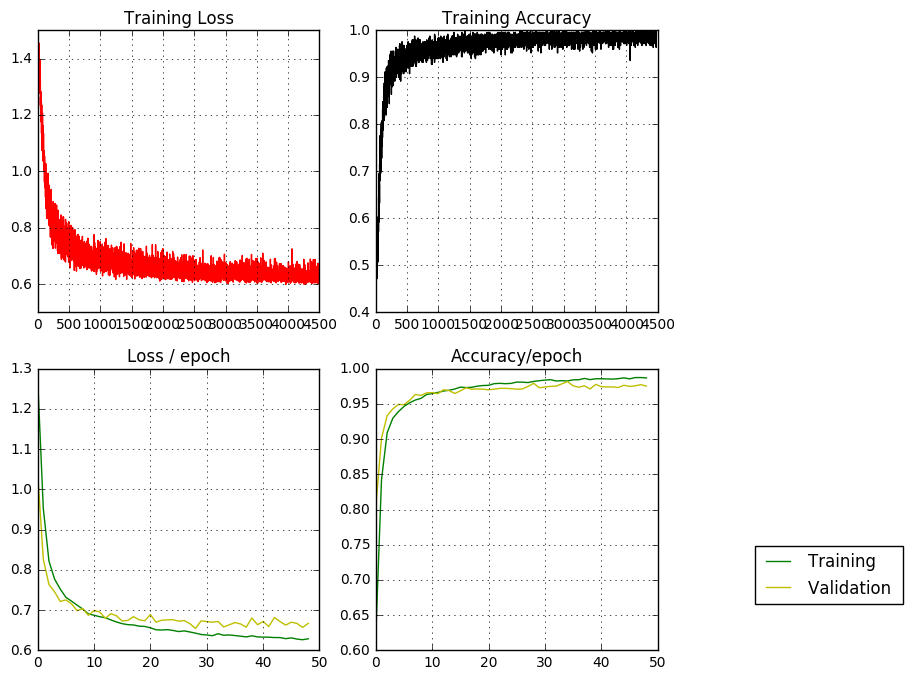

==============*TRAINING INFO*====================
Epoch 50 Iteration 22405
Processed 17750 / 22501
Accuracy in last 5 steps:  0.996
Training Loss in last 5 steps: 0.603712


KeyboardInterrupt: 

In [11]:
with tf.Session() as sess:
    
    if PRETRAINED_MODEL_PATH:
        print "Using Pretrained model"
        saver.restore(sess, PRETRAINED_MODEL_PATH)
    else:    
        sess.run(tf.initialize_all_variables())    
    #sess.run(tf.initialize_local_variables())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    loss_list, accuracy_list, validation_list, validation_loss = [], [], [], []
    plot_loss, plot_accuracy, plot_validation, plot_validation_loss = [], [], [], []
    store_epoch_time = []
    epoch_train_loss, epoch_train_accuracy = [], []
    train_loss_list, train_acc_list = [], []
    
    
    steps = 1
    batch_count = 1
    
    for epoch in range(200):    
        
        train_correct = 0
        train_data = 0    
        epoch_start_time = time.time()
        
        for i in range (450):           #(trainset/BATCH_SIZE +1): 4595
            train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
            _, loss_val, off_acc= sess.run([train_op, loss_tf, accuracy], feed_dict={
                    learning_rate: INIT_LEARNING_RATE, images_tf: train_imbatch, labels_tf: train_labatch})
            
            loss_list.append(loss_val)                              # This must be for visualizing loss curve 
            accuracy_list.append(off_acc)
            epoch_train_loss.append(loss_val)
            epoch_train_accuracy.append(off_acc)

            if (steps) % 5 == 0:   # after 5 batches
                plt.clf()
                display.clear_output(wait=True)
                accuracy_5steps = np.mean(accuracy_list)
                loss_5steps = np.mean(loss_list)
                
                plot_accuracy.append(accuracy_5steps)
                plot_loss.append(loss_5steps)
                
                

                fig = plt.figure(figsize=(8,8))

                ax1 = fig.add_subplot(221)
                ax1.plot(plot_loss,'r-')
                #ax1.legend(bbox_to_anchor=(1, 1.22))
                ax1.grid(True)
                ax1.set_title('Training Loss')
                #ax1.axis('off')
                
                ax2 = fig.add_subplot(222)
                ax2.plot(plot_accuracy,'k-')
                #ax2.legend(bbox_to_anchor=(1, 1.22))
                ax2.grid(True)
                ax2.set_title('Training Accuracy')
                #ax2.axis('off')
                
                ax3 = fig.add_subplot(223)
                ax3.plot(train_loss_list,'g-', label='Training Loss')
                ax3.plot(plot_validation_loss,'y-', label='Validation Loss')
                #ax3.legend(bbox_to_anchor=(0.5, 0.1))
                ax3.grid(True)
                ax3.set_title('Loss / epoch')
                #ax3.axis('off')
                
                ax4 = fig.add_subplot(224)
                ax4.plot(train_acc_list,'g-', label='Training ')
                ax4.plot(plot_validation,'y-', label='Validation ')
                ax4.legend(bbox_to_anchor=(1.9, 0.4))
                ax4.grid(True)
                ax4.set_title('Accuracy/epoch')
                #ax4.axis('off')

                plt.show()
                plt.pause(0.00001)
                #plt.draw()
                print "==============*TRAINING INFO*===================="
                print "Epoch", epoch+1, "Iteration", steps
                print "Processed", batch_count*BATCH_SIZE, '/', trainset               # (count*BATCH_SIZE)
                print 'Accuracy in last 5 steps: ', accuracy_5steps
                print "Training Loss in last 5 steps:", loss_5steps
                loss_list = []
                accuracy_list = []
            steps += 1
            batch_count += 1
        
        train_loss_list.append(np.mean(epoch_train_loss))
        train_acc_list.append(np.mean(epoch_train_accuracy))
        epoch_train_loss, epoch_train_accuracy = [], []
        
        batch_count =1
        n_correct = 0
        n_data = 0
        epoch_time = (time.time() - epoch_start_time)/60.
        store_epoch_time.append(epoch_time)
        print 'Time Elapsed for Epoch:'+str(epoch+1)+' is '+str (epoch_time) +' minutes'
        
        for i in range (50):
            
            val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
            val_accuracy, val_loss = sess.run([accuracy,loss_tf], feed_dict={images_tf:val_imbatch, labels_tf: val_labatch})
            validation_list.append(val_accuracy)
            validation_loss.append(val_loss)
            
        validation_accuracy = np.mean(validation_list)
        plot_validation.append(validation_accuracy)
        plot_validation_loss.append(np.mean(validation_loss))
        validation_list, validation_loss = [], []
        
        #print "===========**VALIDATION ACCURACY**================"
        #print 'epoch:'+str(epoch+1)+'\taccuracy:'+str(validation_accuracy) + '\n'
        
        print 'Time Elapsed for Epoch:'+str(epoch+1)+' is '+str (epoch_time) +' minutes'

        INIT_LEARNING_RATE *= 0.96
        if ((epoch+1) % 1 == 0 or validation_accuracy >=0.90):            
            saver.save(sess, ckpt_dir + "/model-train_BN_512_32x32.ckpt", global_step=epoch)

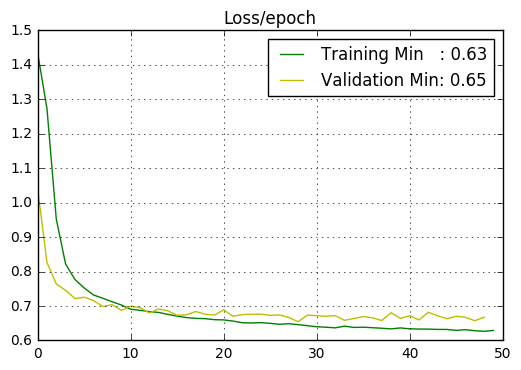

In [12]:
train_loss_copy = train_loss_list
first_loss_pt =  plot_loss[0]
complete_loss = [first_loss_pt] + train_loss_copy
plt.plot(complete_loss, 'g-', label='Training Min   : %0.2f' % min(complete_loss))
plt.plot(plot_validation_loss,'y-', label='Validation Min: %0.2f' % min(plot_validation_loss))
plt.title('Loss/epoch')
plt.legend(bbox_to_anchor=(1., 1.))
plt.grid(True)

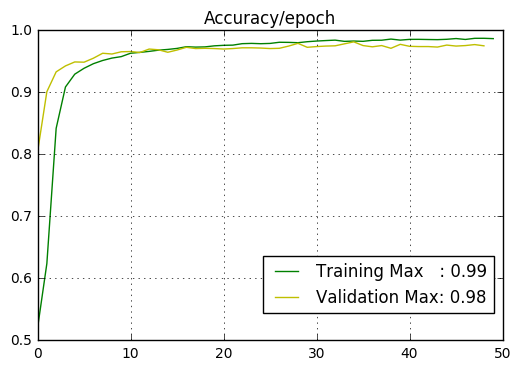

In [13]:
train_acc_copy = train_acc_list
first_acc_pt =  plot_accuracy[0]
complete_acc = [first_acc_pt] + train_acc_copy
plt.plot(complete_acc, 'g-', label='Training Max   : %0.2f' % max(complete_acc))
plt.plot(plot_validation,'y-', label='Validation Max: %0.2f' % max(plot_validation))
plt.title('Accuracy/epoch')
plt.legend(bbox_to_anchor=(1., 0.3))
plt.grid(True)

In [14]:
print np.argmax(plot_validation)
print plot_validation #Thats validation accuracy

34
[0.80399996, 0.90120006, 0.9332, 0.94279999, 0.94919997, 0.94879997, 0.95519996, 0.96319997, 0.96199989, 0.96559995, 0.96599996, 0.96439993, 0.97000003, 0.96879995, 0.96480006, 0.96840006, 0.97280002, 0.97080004, 0.97120005, 0.97080004, 0.97000003, 0.97080004, 0.97200006, 0.97199994, 0.97160006, 0.97080004, 0.97120005, 0.97480005, 0.97920007, 0.9727999, 0.97399992, 0.97480005, 0.97520006, 0.97839999, 0.98160005, 0.97560006, 0.97360003, 0.9756, 0.97120005, 0.97760004, 0.97440004, 0.9740001, 0.97400004, 0.97320008, 0.97640002, 0.97480005, 0.9756, 0.97720003, 0.97520006]
